## Loading Data

In [41]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/DeepLearning/MC/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!pip install stopwords

In [1]:
import re
import nltk
import string
import stopwords
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

import torch
from transformers import DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

In [2]:
df = pd.read_csv("data/spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))

df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


## Data Analysis

In [3]:
balance_counts = df.groupby('target')['target'].agg('count').values
print("Spam:", balance_counts[1], "Ham:", balance_counts[0])

Spam: 747 Ham: 4825


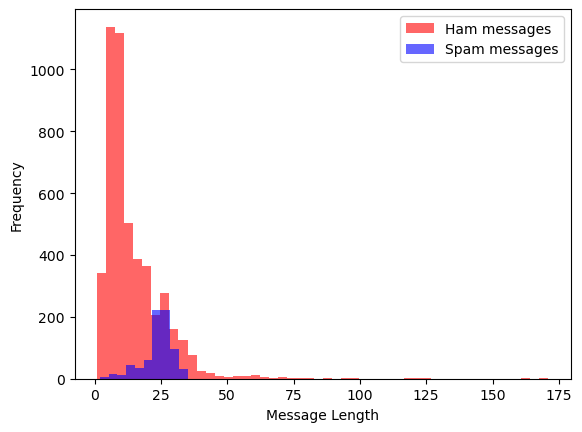

In [5]:
# Plot message length distribution with respect to class
plt.figure()
df[df.target == 'ham'].message_len.plot(bins=50, kind='hist', color='red', label='Ham messages', alpha=0.6)
df[df.target == 'spam'].message_len.plot(bins=10, kind='hist', color='blue', label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")
plt.show()

## Preprocessing

In [47]:
stop_words = stopwords.get_stopwords(language='en')
stemmer = nltk.SnowballStemmer("english")
le = LabelEncoder()
le.fit(df['target'])

def clean_text(text):
    '''
    Make text lowercase, remove text in square brackets, links, punctuation and words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

def preprocess_data(text):
    # Clean punctuation, urls, and so on
    text = clean_text(text)
    # Remove stop words
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stem all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text

In [48]:
df['message_clean'] = df['message'].apply(preprocess_data)
df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts may...,1
3,ham,U dun say so early hor... U c already then say...,11,u dun say earli hor u c alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


## Dataset

In [49]:
class SpamDataset(Dataset):
    def __init__(self, messages, targets, tokenizer, max_len):
        self.messages = messages
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.messages)

    def __getitem__(self, item):
        message = str(self.messages[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'message_text': message,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

df_train = df.sample(frac=0.8, random_state=42)
df_val = df.drop(df_train.index).reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SpamDataset(
        messages=df.message_clean.to_numpy(),
        targets=df.target_encoded.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

BATCH_SIZE = 32
MAX_LEN = 128

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Model

In [50]:
# # DistilBERT model for text classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs[0], dim=1)
        loss = loss_fn(outputs[0], targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, losses

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs[0], dim=1)
            loss = loss_fn(outputs[0], targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, losses

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [51]:
def train_val(model, train_data_loader, val_data_loader, optimizer, loss_fn, device):
    # Wrap train_data_loader with tqdm for progress bar
    train_acc, train_loss = train_epoch(
        model,
        tqdm(train_data_loader, desc='Training', leave=False),
        loss_fn,
        optimizer,
        device,
        len(df_train)
    )

    print(f'Train loss: {np.mean(train_loss):.4f}, Train accuracy: {train_acc:.4f}')

    # Wrap val_data_loader with tqdm for progress bar
    val_acc, val_loss = eval_model(
        model,
        tqdm(val_data_loader, desc='Validation', leave=False),
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss: {np.mean(val_loss):.4f}, Val accuracy: {val_acc:.4f}')
    print()

    return train_acc, train_loss, val_acc, val_loss

In [52]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=1e-6, correct_bias=False, no_deprecation_warning=True)

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')

    train_acc, train_loss, val_acc, val_loss = train_val(
        model,
        train_data_loader,
        val_data_loader,
        optimizer,
        torch.nn.CrossEntropyLoss(),
        device
    )

    for loss in train_loss:
        history['train_loss_iter'].append(loss)

    history['train_loss'].append(np.mean(train_loss))
    history['val_loss'].append(np.mean(val_loss))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model_weights.pth')
        best_accuracy = val_acc
        print("Model saved with validation accuracy:", best_accuracy.item())
        print()

Epoch 1/5


Train loss: 0.3139, Train accuracy: 0.8820


Val loss: 0.1638, Val accuracy: 0.9560

Model saved with validation accuracy: 0.9560143626570916

Epoch 2/5


Train loss: 0.1156, Train accuracy: 0.9677


Val loss: 0.1169, Val accuracy: 0.9632

Model saved with validation accuracy: 0.9631956912028725

Epoch 3/5


Train loss: 0.0753, Train accuracy: 0.9796


Val loss: 0.1036, Val accuracy: 0.9695

Model saved with validation accuracy: 0.9694793536804309

Epoch 4/5


Train loss: 0.0603, Train accuracy: 0.9841


Val loss: 0.0988, Val accuracy: 0.9713

Model saved with validation accuracy: 0.9712746858168761

Epoch 5/5


Train loss: 0.0512, Train accuracy: 0.9870


Val loss: 0.0969, Val accuracy: 0.9740

Model saved with validation accuracy: 0.973967684021544



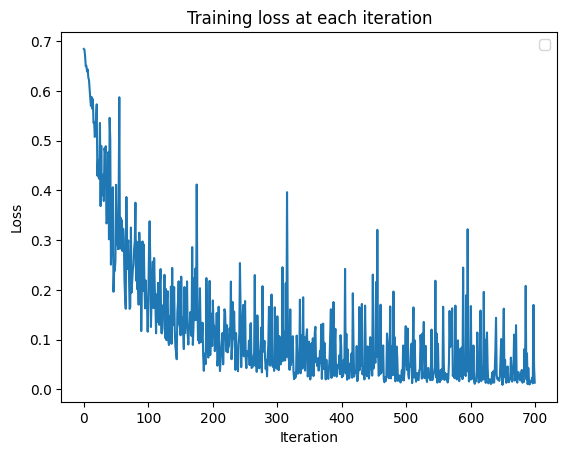

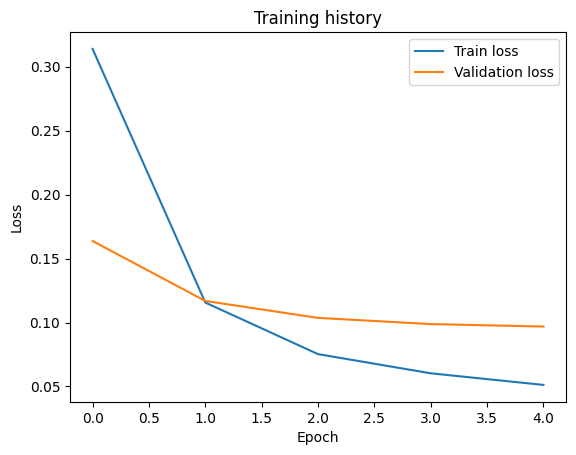

In [53]:
plt.plot(history['train_loss_iter'])

plt.title('Training loss at each iteration')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

plt.plot(history['train_loss'], label='Train loss')
plt.plot(history['val_loss'], label='Validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Cross Validation

In [55]:
# Perform 3-fold cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold = 1
EPOCHS = 3

for train_index, test_index in kf.split(df):
    print(f"Fold {fold} of 3:")
    fold += 1
    df_train = df.iloc[train_index]
    df_val = df.iloc[test_index]

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False, no_deprecation_warning=True)

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')

        train_acc, train_loss, val_acc, val_loss = train_val(
            model,
            train_data_loader,
            val_data_loader,
            optimizer,
            torch.nn.CrossEntropyLoss(),
            device
        )

    accuracies.append(val_acc.item())

    preds = []
    targets = []

    with torch.no_grad():
        for d in val_data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            target = d["targets"].to(device)

            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(output[0], dim=1)

            preds.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    tp = np.sum((preds == 1) & (targets == 1))
    tn = np.sum((preds == 0) & (targets == 0))
    fp = np.sum((preds == 1) & (targets == 0))
    fn = np.sum((preds == 0) & (targets == 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    print(f"Accuracy: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
    print()

Fold 1 of 3:


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Train loss: 0.2345, Train accuracy: 0.9173


Val loss: 0.0988, Val accuracy: 0.9693

Epoch 2/3


Train loss: 0.0838, Train accuracy: 0.9733


Val loss: 0.0803, Val accuracy: 0.9731

Epoch 3/3


Train loss: 0.0532, Train accuracy: 0.9863


Val loss: 0.0716, Val accuracy: 0.9806

Accuracy: 0.9806, Precision: 0.9542, Recall: 0.9016, F1 Score: 0.9271

Fold 2 of 3:


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Train loss: 0.2404, Train accuracy: 0.9007


Val loss: 0.1029, Val accuracy: 0.9693

Epoch 2/3


Train loss: 0.0860, Train accuracy: 0.9742


Val loss: 0.0787, Val accuracy: 0.9763

Epoch 3/3


Train loss: 0.0607, Train accuracy: 0.9844


Val loss: 0.0713, Val accuracy: 0.9779

Accuracy: 0.9779, Precision: 0.9359, Recall: 0.8939, F1 Score: 0.9144

Fold 3 of 3:


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Train loss: 0.2319, Train accuracy: 0.9166


Val loss: 0.1106, Val accuracy: 0.9688

Epoch 2/3


Train loss: 0.0816, Train accuracy: 0.9744


Val loss: 0.0900, Val accuracy: 0.9752

Epoch 3/3


Train loss: 0.0567, Train accuracy: 0.9817


Val loss: 0.0840, Val accuracy: 0.9768

Accuracy: 0.9768, Precision: 0.9638, Recall: 0.8589, F1 Score: 0.9083



In [56]:
# Print the result of 3-fold cross validation
print(f"Average accuracy: {np.mean(accuracies):.4f} in", accuracies)
print(f"Average precision: {np.mean(precisions):.4f} in", precisions)
print(f"Average recall: {np.mean(recalls):.4f} in", recalls)
print(f"Average F1 score: {np.mean(f1_scores):.4f} in", f1_scores)

Average accuracy: 0.9785 in [0.9806243272335844, 0.9779213785675821, 0.9768443726440496]
Average precision: 0.9513 in [0.9541666666666667, 0.9358974358974359, 0.9638009049773756]
Average recall: 0.8848 in [0.9015748031496063, 0.8938775510204081, 0.8588709677419355]
Average F1 score: 0.9166 in [0.9271255060728744, 0.9144050104384134, 0.9083155650319829]
